In [1]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm
p=print
import datetime

C:\Users\HP\AppData\Local\Temp/ipykernel_3880/4244544400.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


            TEDRATE  T10Y2Y  T10Y3M     CMCSA      sret
2002-01-03     0.18    1.97    3.43  9.107717 -0.008389
2002-01-04     0.18    1.99    3.46  8.926126 -0.020140
2002-01-07     0.21    2.01    3.41  9.046335  0.013377
2002-01-08     0.19    2.03    3.42  9.399285  0.038274
2002-01-09     0.19    2.07    3.42  9.350694 -0.005183


<AxesSubplot:>

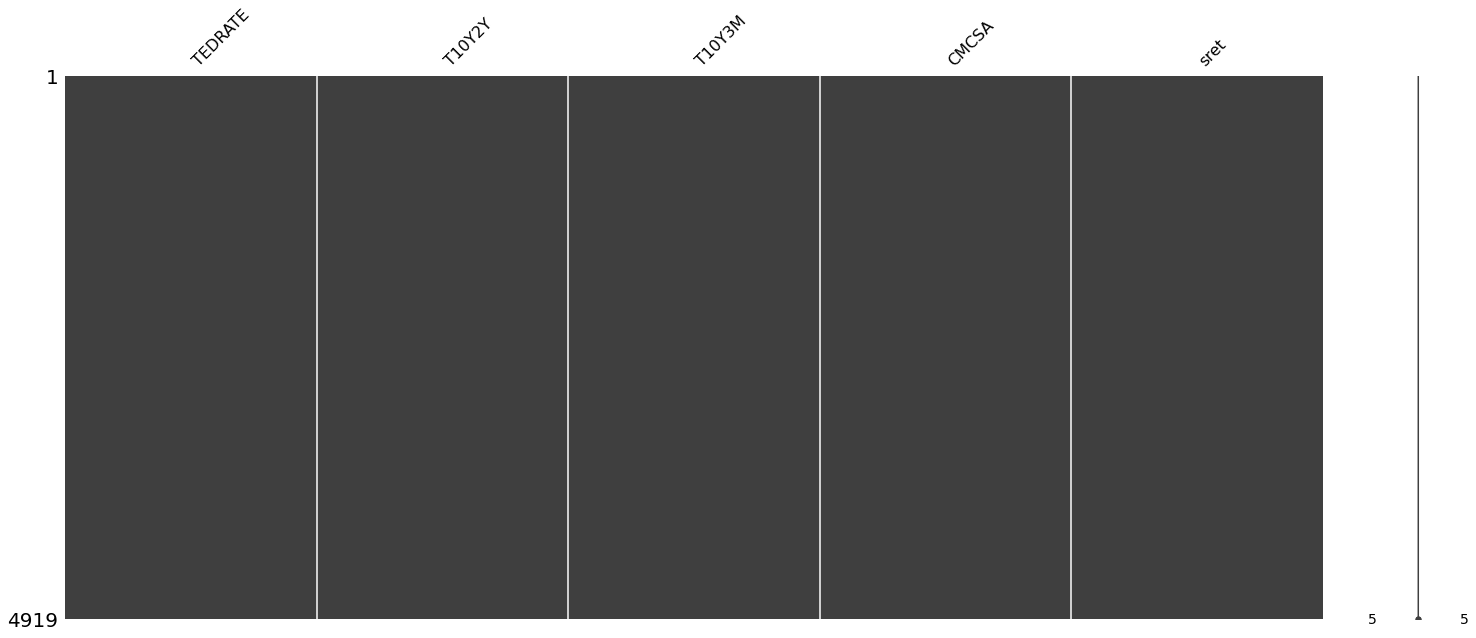

In [2]:
# get fed data

f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

mkt = 'CMCSA'
MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
       .rename(columns={mkt:mkt})
       .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
       .dropna())

data = (web.DataReader([f1, f2, f3], 'fred', start, end)
        .join(MKT, how='inner')
        .dropna()
       )

p(data.head())

# gives us a quick visual inspection of the data
msno.matrix(data)

Means and vars of each hidden state
0th hidden state
mean =  [2.26020489e-01 2.05316615e+00 2.63234081e+00 6.20131354e-04]
var =  [4.01004248e-03 2.17252257e-01 4.01657807e-01 2.83616883e-04]

1th hidden state
mean =  [3.38874060e-01 5.42543516e-01 8.08141239e-01 5.43646704e-04]
var =  [2.26713209e-02 2.11039915e-01 5.21164477e-01 1.46794518e-04]

2th hidden state
mean =  [ 1.04125692e+00  1.52258639e+00  1.97949815e+00 -1.33788378e-03]
var =  [0.52307166 0.39562393 0.84299429 0.00133433]



findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


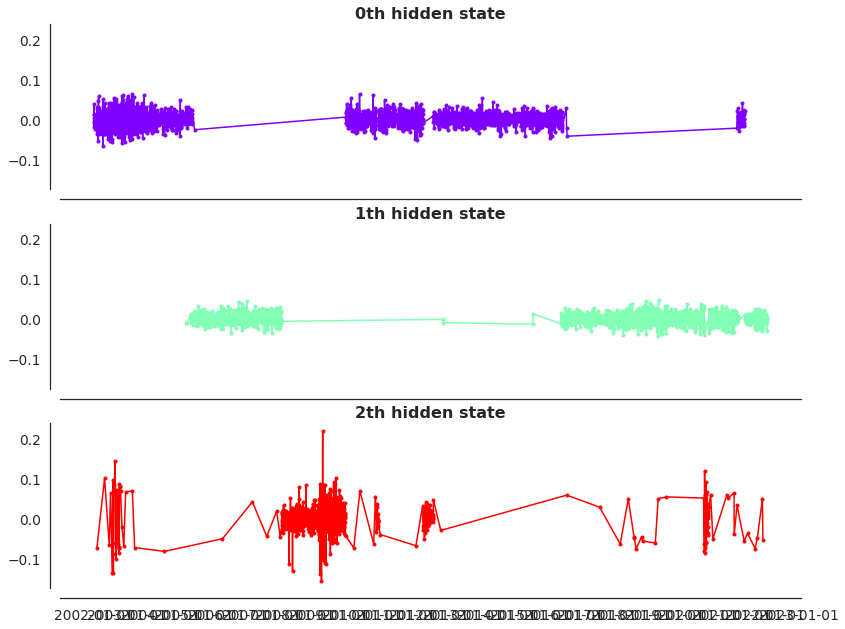

In [3]:
# code adapted from http://hmmlearn.readthedocs.io
# for sklearn 18.1

col = 'sret'
select = data.loc[:].dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 1, 'ytick.major.size': 1,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)
plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

C:\Users\HP\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


        Date  states  TEDRATE  T10Y2Y  T10Y3M     CMCSA      sret  mkt_cret
0 2002-01-03       0     0.18    1.97    3.43  9.107717 -0.008389 -0.008389
1 2002-01-04       0     0.18    1.99    3.46  8.926126 -0.020140 -0.028529
2 2002-01-07       0     0.21    2.01    3.41  9.046335  0.013377 -0.015152
3 2002-01-08       0     0.19    2.03    3.42  9.399285  0.038274  0.023122
4 2002-01-09       0     0.19    2.07    3.42  9.350694 -0.005183  0.017939


findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


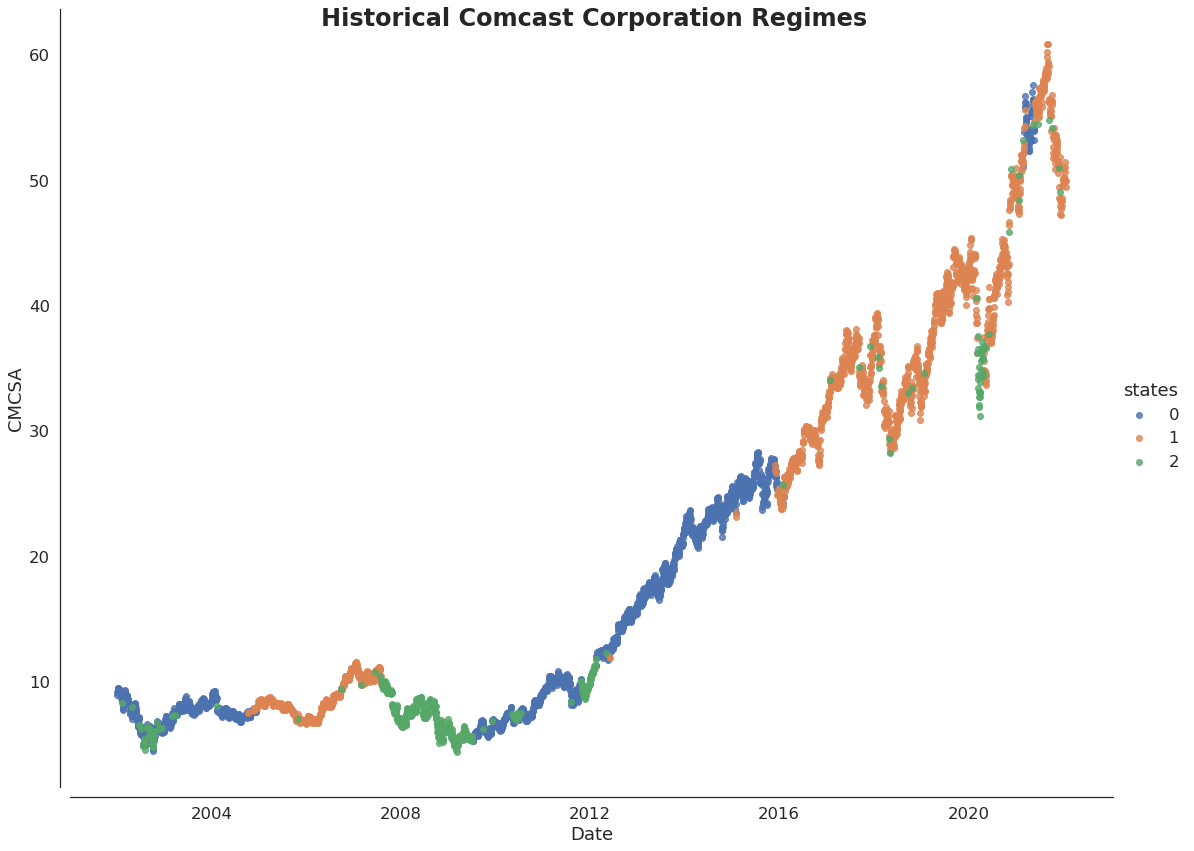

In [4]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical Comcast Corporation Regimes', fontsize=24, fontweight='demi')
fg.savefig('Hidden Markov (Mixture) Model_CMCSA Regimes.png')

In [5]:
## Finding Equillibrium Matrix

In [6]:
start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

df = web.DataReader("CMCSA", 'yahoo', start, end)
df

C:\Users\HP\AppData\Local\Temp/ipykernel_3880/629996965.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-02,12.013333,11.796667,12.010000,11.970000,970200.0,9.184446
2002-01-03,12.063333,11.733333,11.966667,11.870000,471300.0,9.107716
2002-01-04,11.926667,11.603333,11.873333,11.633333,887100.0,8.926126
2002-01-07,11.833333,11.613333,11.630000,11.790000,418200.0,9.046334
2002-01-08,12.250000,11.733333,11.853333,12.250000,742200.0,9.399286
...,...,...,...,...,...,...
2022-04-25,45.869999,44.860001,45.419998,45.709999,28083200.0,45.709999
2022-04-26,45.849998,44.490002,45.290001,44.570000,29225000.0,44.570000
2022-04-27,45.080002,44.080002,44.610001,44.450001,25547900.0,44.450001


In [7]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0.001) else ('Downside' if (x<=0.001) else 'Consolidation'))
df

,High,Low,Open,Close,Volume,Adj Close,state
Date,,,,,,,
2002-01-02,12.013333,11.796667,12.010000,11.970000,970200.0,9.184446,Consolidation
2002-01-03,12.063333,11.733333,11.966667,11.870000,471300.0,9.107716,Downside
2002-01-04,11.926667,11.603333,11.873333,11.633333,887100.0,8.926126,Downside
2002-01-07,11.833333,11.613333,11.630000,11.790000,418200.0,9.046334,Upside
2002-01-08,12.250000,11.733333,11.853333,12.250000,742200.0,9.399286,Upside
...,...,...,...,...,...,...,...
2022-04-25,45.869999,44.860001,45.419998,45.709999,28083200.0,45.709999,Upside
2022-04-26,45.849998,44.490002,45.290001,44.570000,29225000.0,44.570000,Downside
2022-04-27,45.080002,44.080002,44.610001,44.450001,25547900.0,44.450001,Downside


In [8]:
df['priorstate']=df['state'].shift(1)
df.tail()

,High,Low,Open,Close,Volume,Adj Close,state,priorstate
Date,,,,,,,,
2022-04-25,45.869999,44.860001,45.419998,45.709999,28083200.0,45.709999,Upside,Downside
2022-04-26,45.849998,44.490002,45.290001,44.570000,29225000.0,44.570000,Downside,Upside
2022-04-27,45.080002,44.080002,44.610001,44.450001,25547900.0,44.450001,Downside,Downside
2022-04-28,43.720001,40.759998,42.730000,41.700001,49934000.0,41.700001,Downside,Downside
2022-04-29,41.820000,39.610001,41.209999,39.759998,44133300.0,39.759998,Downside,Downside


In [9]:
# Transition Matrix for Markov Chain Model

In [10]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0.001) else ('Downside' if (x<=0.001) else 'Consolidation'))

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
print(transition_matrix)

state          Downside    Upside
priorstate                       
Consolidation  1.000000  0.000000
Downside       0.503170  0.496830
Upside         0.547023  0.452977


In [11]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0) else 'Downside' )

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
print(transition_matrix)

state       Downside    Upside
priorstate                    
Downside    0.479636  0.520364
Upside      0.508501  0.491499


In [12]:
t_0 = transition_matrix.copy()
t_1 =t_0.dot(t_0)
t_1

state,Downside,Upside
priorstate,,
Downside,0.494656,0.505344
Upside,0.493823,0.506177


In [13]:
## Equilibrium Matrix using Python

t_0 = transition_matrix.copy()

t_m = t_0.copy()
t_n = t_0.dot(t_0)

i = 1
while(not(t_m.equals(t_n))):
    i += 1
    t_m = t_n.copy()
    t_n = t_n.dot(t_0)

print("Equilibrium Matrix Number: " + str(i))
print(t_n)

Equilibrium Matrix Number: 11
state       Downside    Upside
priorstate                    
Downside    0.494235  0.505765
Upside      0.494235  0.505765


In [14]:
##Random Walk

symbol = "CMCSA"
days = 10000
end_date = datetime.datetime.now().strftime("%d-%b-%Y")
end_date = str(end_date)

start_date = (datetime.datetime.now()- datetime.timedelta(days=days)).strftime("%d-%b-%Y")
start_date = str(start_date)

#df=index_history("SPY",start_date,end_date)
df = web.DataReader("CMCSA", 'yahoo', start_date, end_date)

df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0) else 'Downside' )

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
t_0 = transition_matrix.copy()

t_m = t_0.copy()
t_n = t_0.dot(t_0)

i = 1
while(not(t_m.equals(t_n))):
    i += 1
    t_m = t_n.copy()
    t_n = t_n.dot(t_0)

print("Equilibrium Matrix Number: " + str(i))
print(t_n)

Equilibrium Matrix Number: 12
state       Downside    Upside
priorstate                    
Downside    0.501523  0.498477
Upside      0.501523  0.498477


In [ ]:
def get_mkt_data(mkt, start, end, factors):
    """Function to get benchmark data from 
        Yahoo and Factor data from FRED
    
    Params:
        mkt : str(), symbol
        start : pd.DateTime()
        end : pd.DateTime()
        factors : list() of str()
    Returns:
        data : pd.DataFrame()
    """
    MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
           .rename(columns={mkt:mkt})
           .assign(lret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
           .dropna())

    data = (web.DataReader(factors, 'fred', start, end)
            .join(MKT, how='inner')
            .dropna())
    return data  

In [ ]:
%load_ext watermark
%watermark
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import scipy.stats as scs

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
import affirm 

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

p=print
p()
%watermark -p pandas,pandas_datareader,numpy,scipy,sklearn,matplotlib,seaborn
# **********************************************************************
def get_mkt_data(mkt, start, end, factors):
    """Function to get benchmark data from 
        Yahoo and Factor data from FRED
    
    Params:
        mkt : str(), symbol
        start : pd.DateTime()
        end : pd.DateTime()
        factors : list() of str()
    Returns:
        data : pd.DataFrame()
    """
    MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
           .rename(columns={mkt:mkt})
           .assign(lret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
           .dropna())

    data = (web.DataReader(factors, 'fred', start, end)
            .join(MKT, how='inner')
            .dropna())
    return data  
# **********************************************************************
class ModelRunner():
    def __init__(self, *args, **kwargs):
        """Class to run mixture model model
        
        Params:
            data : pd.DataFrame()
            ft_cols : list() of feature columns str()
            k : int(), n_components
            max_iter : int(), max iterations
            init : str() {random, kmeans}
        """
        self.data = data
        self.ft_cols = ft_cols
        self.k = k
        self.max_iter = max_iter
        self.init = init
        
        np.random.seed(123457)  # make results reproducible
        
    def _run_model(self, bgm=None, **kwargs):
        """Function to run mixture model

        Params:
            data : pd.DataFrame() 
            ft_cols : list of str() 
            k : int(), n_components
            max_iter : int()
            init : str() {random, kmeans}

        Returns:
            model : sklearn model object
            hidden_states : array-like, hidden states
        """
        X = self.data[self.ft_cols].values

        if bgm:
            model = mix.BayesianGaussianMixture(n_components=self.k, 
                                                max_iter=self.max_iter, 
                                                init_params=self.init,                                            
                                                **kwargs,
                                               ).fit(X)
        else:
            model = mix.GaussianMixture(n_components=self.k, 
                                        max_iter=self.max_iter, 
                                        init_params=self.init,
                                        **kwargs,
                                       ).fit(X)

        hidden_states = model.predict(X)
        return model, hidden_states    
    
    def _get_state_est(self, model, hidden_states):
        """Function to return estimated state mean and state variance

        Params:
            model : sklearn model object
            hidden_states : {array-like}
        Returns:
            mr_i : mean return of last estimated state
            mvar_i : model variance of last estimated state
        """
        # get last state
        last_state = hidden_states[-1]
        # last value is mean return for ith state
        mr_i = model.means_[last_state][-1] 
        mvar_i = np.diag(model.covariances_[last_state])[-1]    
        return mr_i, mvar_i   
    
    def _get_ci(self, mr_i, mvar_i, alpha, a, b, nSamples):
        """Function to sample confidence intervals 
            from the JohnsonSU distribution

        Params:
            mr_i : float()
            mvar_i : float()
            alpha : float()
            a : float()
            b : float() 
            nsamples : int()
        Returns:
            ci : tuple(float(), float()), (low_ci, high_ci) 
        """
        rvs_ = scs.johnsonsu.rvs(a, b, loc=mr_i, scale=mvar_i, size=nSamples)
        ci = scs.johnsonsu.interval(alpha=alpha, a=a, b=b,
                                    loc=np.mean(rvs_), scale=np.std(rvs_))
        return ci
    
    def prediction_cycle(self, *args, **kwargs):  
        """Function to make walk forward predictions from cutoff year onwards
        
        Params:
            year : int(), cutoff year
            alpha : float()
            a : float()
            b : float() 
            nsamples : int()
        Returns:
            dict() :
                pred : pd.DataFrame()
                year : str()
                a, b : float(), float()
        """
        cutoff = year
        train_df = self.data.ix[str(cutoff - lookback):str(cutoff)].dropna()
        oos = self.data.ix[str(cutoff+1):].dropna()
        # confirm that train_df end index is different than oos start index
        assert train_df.index[-1] != oos.index[0]

        # create pred list to hold tuple rows
        preds = []
        for t in tqdm(oos.index):
            if t == oos.index[0]:
                insample = train_df

            # run model func to return model object and hidden states using params
            model, hstates = self._run_model(**kwargs)
            # get hidden state mean and variance
            mr_i, mvar_i = self._get_state_est(model, hstates)
            # get confidence intervals from sampled distribution
            low_ci, high_ci = self._get_ci(mr_i, mvar_i, alpha, a, b, nSamples)
            # append tuple row to pred list
            preds.append((t, hstates[-1], mr_i, mvar_i, low_ci, high_ci))

            # increment insample dataframe 
            insample = data.ix[:t] 

        cols = ['ith_state', 'ith_ret', 'ith_var', 'low_ci', 'high_ci']
        pred = (pd.DataFrame(preds, columns=['Dates']+cols)
                .set_index('Dates').assign(tgt = oos['lret']))

        # logic to see if error exceeds neg or pos CI
        pred_copy = pred.copy().reset_index()
        # Identify indices where target return falls between CI
        win = pred_copy.query("low_ci < tgt < high_ci").index
        # create list of binary variables representing in/out CI
        in_rng_list = [1 if i in win else 0 for i in pred_copy.index]
        # assign binary variables sequence to new column
        pred['in_rng'] = in_rng_list
        return {'pred':pred, 'year':year, 'a':a, 'b':b}  

# **********************************************************************
class ResultEval():
    def __init__(self, data, step_fwd):
        """Class to evaluate prediction results
        
        Params:
            data : dict() containing results of ModelRunner()
            step_fwd : int(), number of days to evalute post event
        """
        self.df = data['pred'].copy().reset_index() 
        self.step_fwd=step_fwd

    def _get_event_states(self):
        """Function to get event indexes
        Index bjects must be called 'too_high', 'too_low'
        
        Returns:
            dict() : values are index objects
        """
        too_high = self.df.query("tgt > high_ci").index
        too_low = self.df.query("tgt < low_ci").index        
        return {'too_high':too_high, 'too_low':too_low}
        
    def get_post_events(self, event):
        """Function to return dictionary where key, value is integer
        index, and Pandas series consisting of returns post event

        Params:
            df : pd.DataFrame(), prediction df
            event : {array-like}, index of target returns that exceed CI high or low
            step_fwd : int(), how many days to include after event
        Returns:
            after_event : dict() w/ values = pd.Series()
        """
        after_event = {}
        for i in range(len(event)):
            tmp_ret = self.df.ix[event[i]:event[i]+self.step_fwd, ['Dates','tgt']]
            # series of returns with date index
            after_event[i] = tmp_ret.set_index('Dates', drop=True).squeeze() 
        return after_event
    
    def get_end_vals(self, post_events):
        """Function to sum and agg each post events' returns"""
        end_vals = []
        for k in post_events.keys():
            tmp = post_events[k].copy()
            tmp.iloc[0] = 0 # set initial return to zero        
            end_vals.append(tmp.sum())
        return end_vals

    def create_summary(self, end_vals):
        """Function to take ending values and calculate summary
        Will fail if count of ending values (>0) or (<0) is less than 1
        """
        gt0 = [x for x in end_vals if x>0]
        lt0 = [x for x in end_vals if x<0]
        assert len(gt0) > 1
        assert len(lt0) > 1
        summary = (pd.DataFrame(index=['value'])
                   .assign(mean = f'{np.mean(end_vals):.4f}')
                   .assign(median = f'{np.median(end_vals):.4f}')
                   .assign(max_ = f'{np.max(end_vals):.4f}')
                   .assign(min_ = f'{np.min(end_vals):.4f}')
                   .assign(gt0_cnt = f'{len(gt0):d}')
                   .assign(lt0_cnt = f'{len(lt0):d}')
                   .assign(sum_gt0 = f'{sum(gt0):.4f}')
                   .assign(sum_lt0 = f'{sum(lt0):.4f}')
                   .assign(sum_ratio = f'{sum(gt0) / abs(sum(lt0)):.4f}')
                   .assign(gt_pct = f'{len(gt0) / (len(gt0) + len(lt0)):.4f}')
                   .assign(lt_pct = f'{len(lt0) / (len(gt0) + len(lt0)):.4f}')
                   )
        return summary
# **********************************************************************
class ModelPlots():
    def __init__(self, mkt, post_events, event_state, project_dir, year):
        """Class to visualize prediction results and summary
        
        Params:
            mkt : str(), symbol
            post_events : dict() of pd.Series()
            event_state : str(), 'too_high', 'too_low'
            project_dir : str()
            year : int(), cutoff year
        """        
        self.mkt = mkt
        self.post_events = post_events
        self.event_state = event_state
        self.DIR = project_dir
        self.year = year

    def plot_equity_timeline(self):
        """Function to plot event timeline with equity curve second axis"""
        agg_tmp = []
        fig, ax = plt.subplots(figsize=(10, 7))
        ax1 = ax.twinx()
        ax.axhline(y=0, color='k', lw=3)
        for k in self.post_events.keys():
            tmp = self.post_events[k].copy()
            tmp.iloc[0] = 0 # set initial return to zero 
            agg_tmp.append(tmp)
            if tmp.sum() > 0: color = 'dodgerblue'
            else: color = 'red'
            ax.plot(tmp.index, tmp.cumsum(), color=color, alpha=0.5)
            ax.set_xlim(pd.to_datetime(str(self.year) + '-12-31'), tmp.index[-1])
            ax.set_xlabel('Dates')
            ax.set_title(f"{self.mkt} {self.event_state.upper()}", fontsize=16)
            #sns.despine(offset=2)   
        agg_df = pd.concat(agg_tmp).cumsum()
        ax1.plot(agg_df.index, agg_df.values, color='k', lw=5)
        ax.set_ylabel('Event Returns')
        ax1.set_ylabel('Equity Curve')
        fig.savefig(self.DIR + f'{self.mkt} {self.event_state.upper()} post events timeline {pd.datetime.today()}.png', dpi=300)
        return    
    
    def plot_events_timeline(self):
        """Function to plot even timeline only"""
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.axhline(y=0, color='k', lw=3)
        for k in self.post_events.keys():
            tmp = self.post_events[k].copy()
            tmp.iloc[0] = 0 # set initial return to zero 

            if tmp.sum() > 0: color = 'dodgerblue'
            else: color = 'red'
            ax.plot(tmp.index, tmp.cumsum(), color=color, alpha=0.5)
            ax.set_xlim(pd.to_datetime('2009-12-31'), tmp.index[-1])
            ax.set_xlabel('Dates')
            ax.set_title(f"{self.mkt} {self.event_state.upper()}", fontsize=16, fontweight='demi')
            sns.despine(offset=2)   
        fig.savefig(self.DIR + f'{self.mkt} {self.event_state.upper()} post events timeline.png', dpi=300)
        return

    def plot_events_post(self):
        """Function to plot events from zero until n days after"""
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.axhline(y=0, color='k', lw=3)
        for k in self.post_events.keys():
            tmp = self.post_events[k].copy()
            tmp.iloc[0] = 0 # set initial return to zero 

            if tmp.sum() > 0: color = 'dodgerblue'
            else: color = 'red'
            tmp.cumsum().reset_index(drop=True).plot(color=color, alpha=0.5, ax=ax)        
        ax.set_xlabel('Days')
        ax.set_title(f"{self.mkt} {self.event_state.upper()}", fontsize=16, fontweight='demi')
        sns.despine(offset=2)  
        fig.savefig(self.DIR + f'{self.mkt} {self.event_state.upper()} post events.png', dpi=300)    
        return

    def plot_distplot(self, ending_values, summary):
        """Function to plot histogram of ending values"""
        colors = sns.color_palette('RdYlBu', 4) 
        fig, ax = plt.subplots(figsize=(10, 7))    
        sns.distplot(pd.DataFrame(ending_values), bins=15, color=colors[0], 
                     kde_kws={"color":colors[3]}, hist_kws={"color":colors[3], "alpha":0.35}, ax=ax)
        ax.axvline(x=float(summary['mean'][0]), label='mean', color='dodgerblue', lw=3, ls='-.')
        ax.axvline(x=float(summary['median'][0]), label='median', color='red', lw=3, ls=':')  
        ax.axvline(x=0, color='black', lw=1, ls='-')
        ax.legend(loc='best')
        sns.despine(offset=2)
        ax.set_title(f"{self.mkt} {self.event_state.upper()}", fontsize=16, fontweight='demi')
        fig.savefig(self.DIR + f'{self.mkt} {self.event_state.upper()} distplot.png', dpi=300)    
        return 

    def plot_pred_results(self, df, year, a, b):
        """Function to plot prediction results and confidence intervals"""
        # colorblind safe palette http://colorbrewer2.org/
        colors = sns.color_palette('RdYlBu', 4)      

        fig, ax = plt.subplots(figsize=(10, 7))   
        ax.scatter(df.index, df.tgt, c=[colors[1] if x==1 else colors[0] for x in df['in_rng']], alpha=0.85)
        df['high_ci'].plot(ax=ax, alpha=0.65, marker='.', color=colors[2])
        df['low_ci'].plot(ax=ax, alpha=0.65, marker='.', color=colors[3])
        ax.set_xlim(df.index[0], df.index[-1])

        nRight = df.query('in_rng==1').shape[0]
        accuracy = nRight / df.shape[0]    
        ax.set_title('{:^10}\ncutoff year: {} | accuracy: {:2.3%} | errors: {} | a={}, b={}'
                      .format(self.mkt, year, accuracy, df.shape[0] - nRight, a, b))

        in_ = mpl.lines.Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=colors[1])
        out_ = mpl.lines.Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=colors[0])
        hi_ci = mpl.lines.Line2D(range(1), range(1), color="white", marker='.', markersize=15, markerfacecolor=colors[2])
        lo_ci = mpl.lines.Line2D(range(1), range(1), color="white", marker='.', markersize=15, markerfacecolor=colors[3])
        leg = ax.legend([in_, out_, hi_ci, lo_ci],["in", "out", 'high_ci', 'low_ci'],
                        loc = "center left", bbox_to_anchor = (1, 0.85), numpoints = 1)    
        sns.despine(offset=2)
        file_str = self.DIR+f'{self.mkt} prediction success {pd.datetime.today()}.png'
        fig.savefig(file_str, dpi=300, bbox_inches="tight")
        return  

In [ ]:
!pip install watermark

In [ ]:
!pip install affirm